## Load data

In [1]:
import os
import cv2
import matplotlib.pyplot as plt


# load images fro images folder
images = [cv2.imread(os.path.join("images", im)) for im in os.listdir("images")]


In [2]:
images[0].shape

(853, 853, 3)

## K-means clustering

In [3]:
import numpy as np

def get_features(img):
    return np.array(img.flatten(), dtype=np.float32)

def k_means(features, k=3, maxIters=1000, starting_centroids = None):
    #assign start centroids
    indexes = np.random.randint(0, features.shape[0], k)
    centroids = np.array(features[indexes])

    if starting_centroids != None:
       centroids = np.array(starting_centroids)
        
    features = np.array(features)
    features = features.reshape((features.shape[0], 1))
    
    for i in range(maxIters):
        # for each feature find minimum distance
        distances = np.zeros((k, features.shape[0]))
        for j in range(centroids.shape[0]):
            centroid = centroids[j]
            distances[j] = np.linalg.norm((features - centroid)**2, axis=1)
            
        nearest_centroids = np.argmin(distances, axis=0)

        # reassign centroids based on that
        centroids_old = np.copy(centroids)
        for j in range(k):
            cluster = features[np.where(nearest_centroids == j)]
            centroids[j] = np.mean(cluster)
        

        if np.linalg.norm(centroids_old - centroids) < .00001:
            print("converged")
            break
            
    
    return centroids_old, nearest_centroids

In [15]:
#image to cluster
test_img = cv2.cvtColor(images[1], cv2.COLOR_BGR2GRAY)

#clustering process
features = get_features(test_img)
centroids, nearest_centroids = k_means(features, k=3)

converged


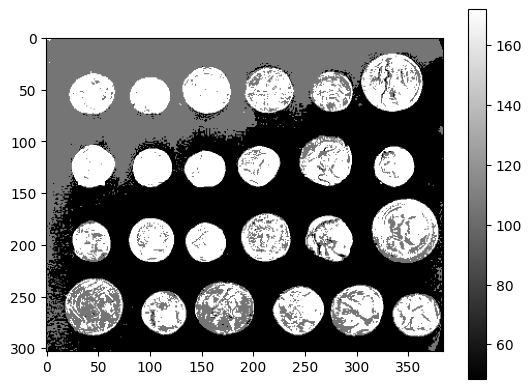

In [16]:
#display clustered image

for i in range(features.shape[0]):
    features[i] = centroids[nearest_centroids[i]]
    
clustered_im = features.reshape(test_img.shape)

plt.imshow(clustered_im, cmap="gray")
plt.colorbar()

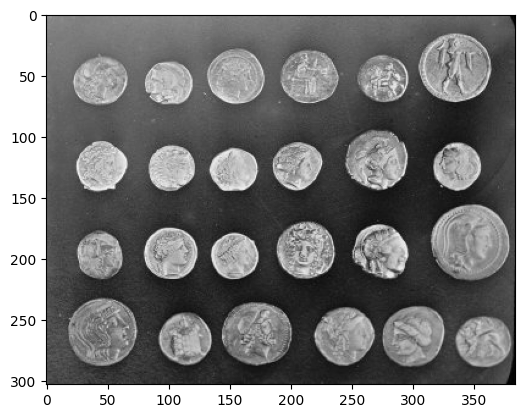

In [10]:
#display original image
plt.imshow(test_img, cmap="gray")

## Otsu thresholding

In [11]:
def mean_and_probability(v):
    intensities, counts = np.unique(v, return_counts=True)
    
    frequencies = counts / v.shape[0]
    
    omega = np.sum(frequencies)

    
    mean = np.sum(np.multiply(intensities, frequencies) / omega)
    
    variance = np.sum(np.multiply(frequencies, (intensities - mean)**2))

    omega = np.sum(frequencies)
    
    return mean, variance
    
    
def interclass_var(features, t):
    # omega_1 = features[features < t].shape[0] / features.shape[0]
    # omega_2 = features[features >= t].shape[0] / features.shape[0]
    
    #print(omega_1)
        
    class1 = features[features < t]
    class2 = features[features >= t]
    #print(features)
        
    mean_1, omega_1 = mean_and_probability(class1)
    mean_2, omega_2 = mean_and_probability(class2)
    
    inter_class = omega_1*omega_2*(mean_1 - mean_2)**2 
    
    return inter_class


def otsu_thresholding(features):
    mini = int(np.min(features))
    maxi = int(np.max(features))
    
    variances = []
    
    for threshold in range(mini, maxi+1):
        variances.append(interclass_var(features, threshold))
        
    #print(variances)
    best_threshold = np.argmax(np.array(variances))
    
    return best_threshold
    

103


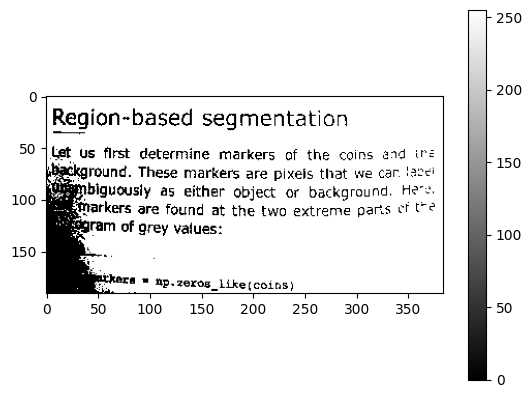

In [12]:
test_img = cv2.cvtColor(images[3], cv2.COLOR_BGR2GRAY)

#clustering process
features = get_features(test_img)
threshold = otsu_thresholding(features)
print(threshold)

blub, threshed_img = cv2.threshold(test_img, threshold, 255, cv2.THRESH_BINARY)

plt.imshow(threshed_img, cmap="gray")
plt.colorbar()

## Denoising / cleaning

In [28]:
def denoise_segmentation(processed_image, big_neighbor=True ,majority_threshold=0.66):
    denoised_im = np.copy(processed_image)
    rows, cols = processed_image.shape

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if big_neighbor == True:
                neighbour_vals = [
                    processed_image[i-1, j-1],
                    processed_image[i-1, j],
                    processed_image[i-1, j+1],
                    processed_image[i, j-1],
                    processed_image[i, j+1],
                    processed_image[i+1, j-1],
                    processed_image[i+1, j],
                    processed_image[i+1, j+1]
                ]
            else:
                neighbour_vals = [
                    processed_image[i-1, j],
                    processed_image[i, j-1],
                    processed_image[i, j+1],
                    processed_image[i+1, j],
                ]
                
            labels = np.bincount(neighbour_vals)
            majority = np.argmax(labels)
            if labels[majority] / len(neighbour_vals) >= majority_threshold:
                denoised_im[i, j] = majority

    return denoised_im

def multiple_denoisings(processed_image, iters=5, big_neighbor=True ,majority_threshold=0.66):
    for i in range(iters):
        processed_image = denoise_segmentation(processed_image, big_neighbor, majority_threshold)
         
    return processed_image

converged


Text(0.5, 1.0, 'Denoised image')

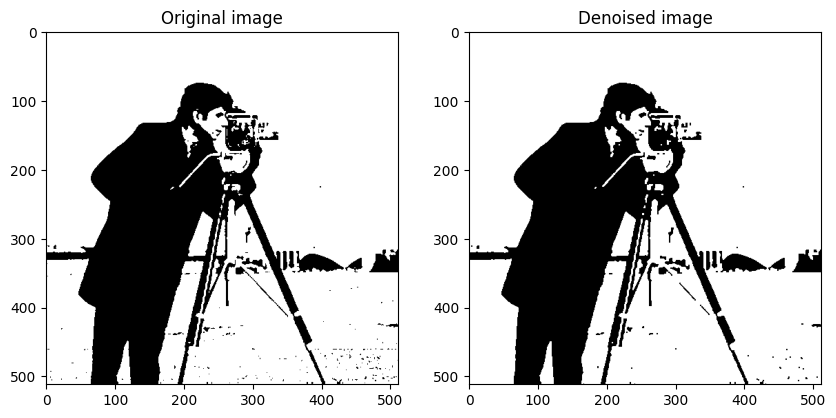

In [30]:
#image to cluster
test_img = cv2.cvtColor(images[2], cv2.COLOR_BGR2GRAY)

#clustering process
features = get_features(test_img)
centroids, nearest_centroids = k_means(features, k=2)

#get clustered im
for i in range(features.shape[0]):
    features[i] = centroids[nearest_centroids[i]]
    
clustered_im = features.reshape(test_img.shape)

# denoise_segmentation(threshed_img) # Testing on otsu
'''
    This tests on normal k-means clustered images. 
    You can keep denoising to get the designated result.
'''
processed_image = multiple_denoisings(clustered_im, iters=20, big_neighbor=False)

figs, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
ax1.imshow(clustered_im, cmap="gray")
ax1.set_title("Original image")
ax2.imshow(processed_image, cmap="gray")
ax2.set_title("Denoised image")